# Predicting a customer's next purchase using automated feature engineering

<p style="margin:30px">
    <img width=50% src="https://www.featuretools.com/wp-content/uploads/2017/12/FeatureLabs-Logo-Tangerine-800.png" alt="Featuretools" />
</p>

**As customers use your product, they leave behind a trail of behaviors that indicate how they will act in the future. Through automated feature engineering we can identify the predictive patterns in granular customer behavioral data that can be used to improve the customer's experience and generate additional revenue for your business.**

In this tutorial, we show how [Featuretools](http://www.featuretools.com) can be used to perform feature engineering on a multi-table dataset of 3 million online grocery orders provided by Instacart. We will generate a feature matrix that can be used to train a machine learning model to predict what product a customer buys next.

*Note: This notebook requires a dataset from Instacart. You can download the dataset [here](https://www.instacart.com/datasets/grocery-shopping-2017). Once you have downloaded the data, be sure to place the CSV files contained in the archive in a directory called `data`. If you use a different directory name, you will need to update the code below to point to the proper location.*

## Highlights

* We automatically generate features using Deep Feature Synthesis and select the 20 most important features for predictive modeling
* We demonstrate how to generate features in a scalable manner using [Dask](http://dask.pydata.org/en/latest/)
* We automatically generate label times using [Compose](https://github.com/FeatureLabs/compose) which can be reused for numerous prediction problems
* We develop a model for predicting what a customer will buy next, starting with a sample of data and then scaling to the full dataset

## You must have Featuretools version 0.16.0 or greater installed to run this notebook

In [1]:
import os
import composeml as cp
import featuretools as ft
import dask.dataframe as dd
import numpy as np
import pandas as pd
import utils
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from dask.distributed import Client
ft.__version__

'0.18.0'

## Step 1. Load and preprocess data

First, we will create a Dask distributed client so we can track the progress of our computation on the Dask dashboard that is created when the client is initialized.

In [2]:
client = Client(n_workers=2)
client

<Client: 'tcp://127.0.0.1:63263' processes=2 threads=16, memory=17.18 GB>

Next, we will specify our input and output directories and set the blocksize we will be using to read the raw CSV files into Dask dataframes. When running on a machine with 16GB of memory available for two Dask workers, a `100MB` blocksize has worked well. This number may need to be adjusted based on your specific environment. Refer to the [Dask documentation](https://docs.dask.org/en/latest/best-practices.html) for additional info.

In [3]:
data_dir = os.path.join("data")
output_dir = os.path.join("data", "dask_data")
blocksize = "100MB"

Now we will read our data into Dask dataframes. This operation will complete quite fast as we are not actually bringing the data into memory at this stage.

In [4]:
order_products = dd.concat([dd.read_csv(os.path.join(data_dir, "order_products__prior.csv"), blocksize=blocksize),
                            dd.read_csv(os.path.join(data_dir, "order_products__train.csv"), blocksize=blocksize)])
orders = dd.read_csv(os.path.join(data_dir, "orders.csv"), blocksize=blocksize)
departments = dd.read_csv(os.path.join(data_dir, "departments.csv"), blocksize=blocksize)
products = dd.read_csv(os.path.join(data_dir, "products.csv"), blocksize=blocksize)

In the next few cells, we will perform some required preprocessing to clean up our data. We will merge together some of the raw dataframes and add absolute order time information from the relative times used in the raw data. This will allow us to use cutoff times as part of the Deep Feature Synthesis process.

In [5]:
order_products = order_products.merge(products).merge(departments)

In [6]:
def add_time(df):
    df.reset_index(drop=True)
    df["order_time"] = np.nan
    days_since = df.columns.tolist().index("days_since_prior_order")
    hour_of_day = df.columns.tolist().index("order_hour_of_day")
    order_time = df.columns.tolist().index("order_time")

    df.iloc[0, order_time] = pd.Timestamp('Jan 1, 2015') +  pd.Timedelta(df.iloc[0, hour_of_day], "h")
    for i in range(1, df.shape[0]):
        df.iloc[i, order_time] = df.iloc[i - 1, order_time] \
            + pd.Timedelta(df.iloc[i, days_since], "d") \
                                    + pd.Timedelta(df.iloc[i, hour_of_day], "h")

    to_drop = ["order_number", "order_dow", "order_hour_of_day", "days_since_prior_order", "eval_set"]
    df.drop(to_drop, axis=1, inplace=True)

    return df

In [7]:
orders = orders.groupby("user_id").apply(add_time, meta={
    "order_id": int,
    "user_id": int,
    "order_time": np.datetime64(0, 'ns').dtype})
order_products = order_products.merge(orders[["order_id", "order_time"]])
order_products["order_product_id"] = order_products["order_id"] * 1000 + order_products["add_to_cart_order"]
order_products = order_products.drop(["product_id", "department_id", "add_to_cart_order"], axis=1)

Now that the preprocessing work is complete, we will save the results to disk. This will allow us to start from this point in the process in the future, without having to repeat all of the preprocessing steps. If you have already saved the results to disk previously, you can skip the cell below.

#### Note: The process of saving to CSV is computationally intensive and may take 45 minutes or more, depending on the system you are using. You can use the Dask dashboard to monitor the progress.

In [8]:
# Save preprocessed data to disk
orders.to_csv(os.path.join(output_dir, "orders-*.csv"), index=False)
order_products.to_csv(os.path.join(output_dir, "order_products-*.csv"), index=False)

['/Users/nate.parsons/dev/featuretools-demos/predict-next-purchase/data/dask_data/order_products-0.csv',
 '/Users/nate.parsons/dev/featuretools-demos/predict-next-purchase/data/dask_data/order_products-1.csv',
 '/Users/nate.parsons/dev/featuretools-demos/predict-next-purchase/data/dask_data/order_products-2.csv',
 '/Users/nate.parsons/dev/featuretools-demos/predict-next-purchase/data/dask_data/order_products-3.csv',
 '/Users/nate.parsons/dev/featuretools-demos/predict-next-purchase/data/dask_data/order_products-4.csv',
 '/Users/nate.parsons/dev/featuretools-demos/predict-next-purchase/data/dask_data/order_products-5.csv',
 '/Users/nate.parsons/dev/featuretools-demos/predict-next-purchase/data/dask_data/order_products-6.csv']

If you have already performed the preprocessing steps and saved the processed files to disk, you can read them in with the commands in the following cell.

In [9]:
# Read preprocessed data from disk
orders = dd.read_csv(os.path.join(output_dir, "orders-*.csv"), blocksize=blocksize)
order_products = dd.read_csv(os.path.join(output_dir, "order_products-*.csv"), blocksize=blocksize)

In [10]:
orders.head()

order_id  user_id           order_time
0   2539329        1  2015-01-01 08:00:00
1   2398795        1  2015-01-16 15:00:00
2    473747        1  2015-02-07 03:00:00
3   2254736        1  2015-03-08 10:00:00
4    431534        1  2015-04-06 01:00:00

In [11]:
order_products.head()

order_id  reordered                                       product_name  \
0       800          1                                 Organic Egg Whites   
1       800          0                      Grilled Chicken Breast Strips   
2       800          0                  Nux Vomica 6C Homeopathic Pellets   
3       800          0              Kava Kava Root, Liquid Herbal Extract   
4       800          0  Sedalia Homeopathic Medicine Stress Relief Qui...   

   aisle_id     department           order_time  order_product_id  
0        86     dairy eggs  2015-01-11 10:00:00            800003  
1        49   meat seafood  2015-01-11 10:00:00            800004  
2        47  personal care  2015-01-11 10:00:00            800005  
3        47  personal care  2015-01-11 10:00:00            800006  
4        47  personal care  2015-01-11 10:00:00            800011

## Step 2: Create a Featuretools entityset

When using Dask dataframes to create an entityset, variable type inference is not performed as it is with entitysets created from pandas dataframes. As a result, users must specify the Featuretools variable types for all of the columns in the dataframes that make up the entityset when using Dask. In the following cell we define the data types for the `order_products` and `orders` entities.

In [12]:
order_products_vtypes = {
    "order_id": ft.variable_types.Id,
    "reordered": ft.variable_types.Boolean,
    "product_name": ft.variable_types.Categorical,
    "aisle_id": ft.variable_types.Categorical,
    "department": ft.variable_types.Categorical,
    "order_time": ft.variable_types.Datetime,
    "order_product_id": ft.variable_types.Index,
}

order_vtypes = {
    "order_id": ft.variable_types.Index,
    "user_id": ft.variable_types.Id,
    "order_time": ft.variable_types.DatetimeTimeIndex,
}

Now that we have defined the data types, we can create the entityset and establish the relationship between the two entities. For our initial run we will use a sample of the full data to determine what features are the best predictors. Once we have the feature importances established we will rerun on the full dataset using only the most important features.

First we will sample our data - grabbing the orders for 1000 different customers. Because we cannot pass a Dask series to `.isin()` we must call `.compute()` on the ids to convert this into a pandas series.

In [13]:
orders_sample = orders[orders['user_id'].isin(range(1001,2001))]

Next we will get the order products associated with the orders we sampled. 

In [14]:
order_products_sample = order_products[order_products['order_id'].isin(orders_sample['order_id'].compute())]

Now that we have sampled our data, we can create an entityset from these sampled dataframes.

In [15]:
es = ft.EntitySet("instacart_sample")
es.entity_from_dataframe(entity_id="order_products",
                         dataframe=order_products_sample,
                         index="order_product_id",
                         variable_types=order_products_vtypes,
                         time_index="order_time")

es.entity_from_dataframe(entity_id="orders",
                         dataframe=orders_sample,
                         index="order_id",
                         variable_types=order_vtypes,
                         time_index="order_time")

es.add_relationship(ft.Relationship(es["orders"]["order_id"], es["order_products"]["order_id"]))

Entityset: instacart_sample
  Entities:
    order_products [Rows: Delayed('int-59de63b6-4eb5-4202-8f98-c2131840b43b'), Columns: 7]
    orders [Rows: Delayed('int-fce6495b-b968-410d-97b7-9fa3e91d972c'), Columns: 3]
  Relationships:
    order_products.order_id -> orders.order_id

Next, we will normalize the `orders` entity to create a new `users` entity that we will later use as the target entity during the deep feature synthesis process.

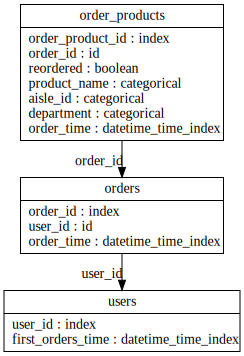

In [16]:
es.normalize_entity(base_entity_id="orders", new_entity_id="users", index="user_id")
es.plot()

To finish up creation of the entity set we will add last time indexes and set some interesting values.

In [17]:
es.add_last_time_indexes()

In [18]:
es["order_products"]["department"].interesting_values = ['produce', 'dairy eggs', 'snacks', 'beverages', 'frozen', 'pantry', 'bakery', 'canned goods', 'deli', 'dry goods pasta']
es["order_products"]["product_name"].interesting_values = ['Banana', 'Bag of Organic Bananas', 'Organic Baby Spinach', 'Organic Strawberries', 'Organic Hass Avocado', 'Organic Avocado', 'Large Lemon', 'Limes', 'Strawberries', 'Organic Whole Milk']

## Step 3. Use Compose to generate our cutoff times dataframe

In the cells that follow we will demonstrate how [Compose](https://github.com/FeatureLabs/compose) can be used to generate the label times dataframe that will be used as cutoff times for deep feature synthesis.

First we define a labeling function to add a label if a user has bought a specific product or not, and then we will create our `LabelMaker` using this function.

In [19]:
def bought_product(df, product_name):
    purchased = df.product_name.str.contains(product_name).any()
    return purchased

In [20]:
lm = cp.LabelMaker(
    target_entity='user_id',
    time_index='order_time',
    labeling_function=bought_product,
    window_size='4w',
)

In [21]:
def denormalize(es):
    df = es['order_products'].df.merge(es['orders'].df).merge(es['users'].df)
    return df

Compose does not currently work on Dask dataframes, so we must first run `.compute()` on the denormalized entityset to switch to pandas.

In [22]:
df = denormalize(es).compute()

Now we can create our labels, indicating whether or not a user has purchased Bananas.

In [23]:
label_times = lm.search(
    df.sort_values('order_time'),
    minimum_data='2015-03-15',
    num_examples_per_instance=2,
    product_name='Banana',
    verbose=True,
)

Elapsed: 00:02 | Remaining: 00:00 | Progress: 100%|██████████| user_id: 2000/2000 


In [24]:
label_times.head()

user_id       time  bought_product
0     1001 2015-03-15           False
1     1001 2015-04-12           False
2     1002 2015-03-15           False
3     1002 2015-04-12           False
4     1003 2015-03-15           False

We can see above the our training examples contain three pieces of information: a user id, the last time we can use data before feature engineering (called the "cutoff time"), and the label to predict. These are called our "label times".

We can use `describe` to print out the distribution with the settings and transforms that were used to make these labels. This is useful as a reference for understanding how the labels were generated from raw data. Also, the label distribution is helpful for determining if we have imbalanced labels.

In [25]:
label_times.describe()

Label Distribution
------------------
False      951
True       499
Total:    1450


Settings
--------
gap                          <4 * Weeks: weekday=6>
minimum_data                             2015-03-15
num_examples_per_instance                         2
target_column                        bought_product
target_entity                               user_id
target_type                                discrete
window_size                  <4 * Weeks: weekday=6>


Transforms
----------
No transforms applied



## Step 4. Run Deep Feature Synthesis

With our label times created, we are ready to run deep feature synthesis to generate our feature matrix. This will execute quickly and the resulting feature matrix will be returned as a Dask dataframe. This process does not cause the feature matrix to be computed or brought into memory.

When we use DFS, we specify
- `target_entity` - the table to build features for - `users` in this case
- `cutoff_time` - the point in time to calculate the features

A good way to think of the `cutoff_time` is that it let's us "pretend" we are at an earlier point in time when generating our features so we can simulate making predictions. We get this time for each customer from the label times we generated above.

For this initial run we will not specify any primitives, which will result in all the default primitives being used to create features.

In [26]:
feature_matrix, features = ft.dfs(target_entity="users",
                                  cutoff_time=label_times,
                                  entityset=es,
                                  verbose=True)

Built 59 features
Elapsed: 00:05 | Progress: 100%|██████████


Now that we have a Dask feature matrix, we can save it to disk for future use along with the features we generated. This process could take some time, but you can monitor the progress using the Dask dashboard.

In [29]:
ft.save_features(features, os.path.join(output_dir, "initial_features.txt"))
feature_matrix.to_csv(os.path.join(output_dir, "initial_feature_matrix-*.csv"), index=False)

['/Users/nate.parsons/dev/featuretools-demos/predict-next-purchase/data/dask_data/initial_feature_matrix-0.csv',
 '/Users/nate.parsons/dev/featuretools-demos/predict-next-purchase/data/dask_data/initial_feature_matrix-1.csv',
 '/Users/nate.parsons/dev/featuretools-demos/predict-next-purchase/data/dask_data/initial_feature_matrix-2.csv']

Next, let's compute the feature matrix and take a look at what we created.

In [30]:
fm = feature_matrix.compute()
fm.head()

COUNT(orders)  COUNT(order_products)  \
0              6                    400   
1              6                    118   
2             20                   1608   
3              8                    116   
4              4                     84   

   PERCENT_TRUE(order_products.reordered)  \
0                                0.280000   
1                                0.203390   
2                                0.597015   
3                                0.413793   
4                                0.047619   

   NUM_UNIQUE(order_products.aisle_id)  NUM_UNIQUE(order_products.department)  \
0                                   25                                     13   
1                                   19                                     10   
2                                   20                                     12   
3                                   21                                      9   
4                                   22                                      7   

   NUM_UNIQUE(order_products.product_name)  DAY(first_orders_time)  \
0                                       36                       1   
1                                       47                       1   
2                                       81                       1   
3                                       34                       1   
4                                       40                       1   

   YEAR(first_orders_time)  MONTH(first_orders_time)  \
0                     2015                         1   
1                     2015                         1   
2                     2015                         1   
3                     2015                         1   
4                     2015                         1   

   WEEKDAY(first_orders_time)  ...  \
0                           3  ...   
1                           3  ...   
2                           3  ...   
3                           3  ...   
4                           3  ...   

   COUNT(order_products WHERE department = frozen)  \
0                                             32.0   
1                                              0.0   
2                                             32.0   
3                                              0.0   
4                                             12.0   

   COUNT(order_products WHERE product_name = Organic Baby Spinach)  \
0                                                0.0                 
1                                                0.0                 
2                                                0.0                 
3                                                4.0                 
4                                                0.0                 

   COUNT(order_products WHERE department = dairy eggs)  \
0                                               32.0     
1                                                4.0     
2                                               56.0     
3                                               18.0     
4                                               18.0     

   COUNT(order_products WHERE product_name = Banana)  \
0                                                0.0   
1                                                2.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   

   COUNT(order_products WHERE department = pantry)  \
0                                              0.0   
1                                             18.0   
2                                             24.0   
3                                             10.0   
4                                              4.0   

   COUNT(order_products WHERE department = snacks)  \
0                                            104.0   
1                                             54.0   
2                                              8.0   
3                         

Before we use this feature matrix to build a predictive model, we will first encode any categorical features using `ft.encode_features()`. Note, at this time `ft.encode_features()` does not work with a Dask feature matrix, so we will use the pandas version we computed above.

In [31]:
fm_encoded, features_encoded = ft.encode_features(fm,
                                                  features)

print("Number of features %s" % len(features_encoded))
fm_encoded.head()

Number of features 63


COUNT(orders)  COUNT(order_products)  \
0              6                    400   
1              6                    118   
2             20                   1608   
3              8                    116   
4              4                     84   

   PERCENT_TRUE(order_products.reordered)  \
0                                0.280000   
1                                0.203390   
2                                0.597015   
3                                0.413793   
4                                0.047619   

   NUM_UNIQUE(order_products.aisle_id)  NUM_UNIQUE(order_products.department)  \
0                                   25                                     13   
1                                   19                                     10   
2                                   20                                     12   
3                                   21                                      9   
4                                   22                                      7   

   NUM_UNIQUE(order_products.product_name)  DAY(first_orders_time) = 1  \
0                                       36                        True   
1                                       47                        True   
2                                       81                        True   
3                                       34                        True   
4                                       40                        True   

   DAY(first_orders_time) is unknown  YEAR(first_orders_time) = 2015  \
0                              False                            True   
1                              False                            True   
2                              False                            True   
3                              False                            True   
4                              False                            True   

   YEAR(first_orders_time) is unknown  ...  \
0                               False  ...   
1                               False  ...   
2                               False  ...   
3                               False  ...   
4                               False  ...   

   COUNT(order_products WHERE department = frozen)  \
0                                             32.0   
1                                              0.0   
2                                             32.0   
3                                              0.0   
4                                             12.0   

   COUNT(order_products WHERE product_name = Organic Baby Spinach)  \
0                                                0.0                 
1                                                0.0                 
2                                                0.0                 
3                                                4.0                 
4                                                0.0                 

   COUNT(order_products WHERE department = dairy eggs)  \
0                                               32.0     
1                                                4.0     
2                                               56.0     
3                                               18.0     
4                                               18.0     

   COUNT(order_products WHERE product_name = Banana)  \
0                                                0.0   
1                                                2.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   

   COUNT(order_products WHERE department = pantry)  \
0                                              0.0   
1                                             18.0   
2                                             24.0   
3                                             10.0   
4                                              4.0   

   COUNT(order_products WHERE department = snacks)  \
0                   

## Step 5. Machine Learning

Using the default parameters, we generated dozens of potential features for our prediction problem. With a few simple commands, this feature matrix can be used for machine learning

In [32]:
X = fm_encoded.drop(["user_id"], axis=1)
X = X.fillna(0)
y = X.pop("bought_product").astype('bool')

In [33]:
X.head()

COUNT(orders)  COUNT(order_products)  \
0              6                    400   
1              6                    118   
2             20                   1608   
3              8                    116   
4              4                     84   

   PERCENT_TRUE(order_products.reordered)  \
0                                0.280000   
1                                0.203390   
2                                0.597015   
3                                0.413793   
4                                0.047619   

   NUM_UNIQUE(order_products.aisle_id)  NUM_UNIQUE(order_products.department)  \
0                                   25                                     13   
1                                   19                                     10   
2                                   20                                     12   
3                                   21                                      9   
4                                   22                                      7   

   NUM_UNIQUE(order_products.product_name)  DAY(first_orders_time) = 1  \
0                                       36                        True   
1                                       47                        True   
2                                       81                        True   
3                                       34                        True   
4                                       40                        True   

   DAY(first_orders_time) is unknown  YEAR(first_orders_time) = 2015  \
0                              False                            True   
1                              False                            True   
2                              False                            True   
3                              False                            True   
4                              False                            True   

   YEAR(first_orders_time) is unknown  ...  \
0                               False  ...   
1                               False  ...   
2                               False  ...   
3                               False  ...   
4                               False  ...   

   COUNT(order_products WHERE product_name = Large Lemon)  \
0                                                0.0        
1                                                0.0        
2                                                0.0        
3                                                0.0        
4                                                2.0        

   COUNT(order_products WHERE department = beverages)  \
0                                                8.0    
1                                                6.0    
2                                               56.0    
3                                                4.0    
4                                                6.0    

   COUNT(order_products WHERE department = frozen)  \
0                                             32.0   
1                                              0.0   
2                                             32.0   
3                                              0.0   
4                                             12.0   

   COUNT(order_products WHERE product_name = Organic Baby Spinach)  \
0                                                0.0                 
1                                                0.0                 
2                                                0.0                 
3                                                4.0                 
4                                                0.0                 

   COUNT(order_products WHERE department = dairy eggs)  \
0                                               32.0     
1                                                4.0     
2                                               56.0     
3                                               18.0     
4                                               18.0     

   COUNT(order_products WH

In [34]:
y.head()

0    False
1    False
2     True
3    False
4     True
Name: bought_product, dtype: bool

Let's train a Random Forest and validate using 3-fold cross validation

In [35]:
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf,X=X, y=y, cv=3,
                         scoring="roc_auc", verbose=True)

"AUC %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s finished


'AUC 0.81 +/- 0.02'

As you can see this model predicts the next purchase better than guessing. 

Next we will identify the top 20 features so we can use them to later perform machine learning on the whole dataset.

In [36]:
clf.fit(X, y)
top_features = utils.feature_importances(clf, features_encoded, n=20)

1: Feature: COUNT(order_products WHERE product_name = Banana), 0.068
2: Feature: COUNT(order_products WHERE product_name = Bag of Organic Bananas), 0.065
3: Feature: COUNT(order_products WHERE department = produce), 0.041
4: Feature: MEAN(orders.NUM_UNIQUE(order_products.product_name)), 0.034
5: Feature: MEAN(orders.NUM_UNIQUE(order_products.aisle_id)), 0.028
6: Feature: NUM_UNIQUE(order_products.product_name), 0.027
7: Feature: MEAN(orders.NUM_UNIQUE(order_products.department)), 0.026
8: Feature: STD(orders.PERCENT_TRUE(order_products.reordered)), 0.026
9: Feature: PERCENT_TRUE(order_products.reordered), 0.026
10: Feature: COUNT(order_products WHERE department = dairy eggs), 0.026
11: Feature: STD(orders.NUM_UNIQUE(order_products.department)), 0.026
12: Feature: STD(orders.NUM_UNIQUE(order_products.product_name)), 0.025
13: Feature: MEAN(orders.PERCENT_TRUE(order_products.reordered)), 0.025
14: Feature: MEAN(orders.COUNT(order_products)), 0.023
15: Feature: STD(orders.COUNT(order_prod

To persist these features, we can save them to disk.

In [37]:
ft.save_features(top_features, os.path.join(data_dir, "top_features.txt"))

### Understanding feature engineering in Featuretools

Before moving forward, take a look at the features we created. You will see that they are more than just simple transformations of columns in our raw data. Instead, they perform aggregations (and sometimes stacking of aggregations) across the relationships in our dataset. If you're curious how this works, learn about the Deep Feature Synthesis algorithm in our documentation [here](https://docs.featuretools.com/en/stable/automated_feature_engineering/afe.html).

DFS is so powerful because with no manual work, the library figured out that historical purchases of bananas are important for predicting future purchases. Additionally, it surfaces that purchasing dairy or eggs and reordering behavior are important features.

Even though these features are intuitive, Deep Feature Synthesis will automatically adapt as we change the prediction problem, saving us the time of manually brainstorming and implementing these data transformation.

## Step 6. Scale to Full Dataset

Now that we have established the most important features, we will repeat the process of creating a feature matrix, using only these features, and then make predictions using our full dataset.

To start, we will create a new entityset containing our full dataset.

In [38]:
es = ft.EntitySet("instacart_full")
es.entity_from_dataframe(entity_id="order_products",
                         dataframe=order_products,
                         index="order_product_id",
                         variable_types=order_products_vtypes,
                         time_index="order_time")

es.entity_from_dataframe(entity_id="orders",
                         dataframe=orders,
                         index="order_id",
                         variable_types=order_vtypes,
                         time_index="order_time")

es.add_relationship(ft.Relationship(es["orders"]["order_id"], es["order_products"]["order_id"]))

Entityset: instacart_full
  Entities:
    order_products [Rows: Delayed('int-20035e3b-a0eb-4b31-8a23-64ac155b5a54'), Columns: 7]
    orders [Rows: Delayed('int-4a331aa5-235a-47e8-ba16-12a72620fb5e'), Columns: 3]
  Relationships:
    order_products.order_id -> orders.order_id

In [39]:
es.normalize_entity(base_entity_id="orders", new_entity_id="users", index="user_id")

Entityset: instacart_full
  Entities:
    order_products [Rows: Delayed('int-98e698ab-a5e3-46f6-a3ba-736ec49c30f9'), Columns: 7]
    orders [Rows: Delayed('int-14130fbc-100a-49c2-8c9a-391d477fe7d3'), Columns: 3]
    users [Rows: Delayed('int-d07f91a0-5eb9-4037-92be-16695dd18ec6'), Columns: 2]
  Relationships:
    order_products.order_id -> orders.order_id
    orders.user_id -> users.user_id

In [40]:
es.add_last_time_indexes()
es["order_products"]["department"].interesting_values = ['produce', 'dairy eggs', 'snacks', 'beverages', 'frozen', 'pantry', 'bakery', 'canned goods', 'deli', 'dry goods pasta']
es["order_products"]["product_name"].interesting_values = ['Banana', 'Bag of Organic Bananas', 'Organic Baby Spinach', 'Organic Strawberries', 'Organic Hass Avocado', 'Organic Avocado', 'Large Lemon', 'Limes', 'Strawberries', 'Organic Whole Milk']

We will use our previously defined Compose label maker to create cutoff times for the full dataset.

In [41]:
df = denormalize(es).compute()

In [42]:
label_times = lm.search(
    df.sort_values('order_time'),
    minimum_data='2015-03-15',
    num_examples_per_instance=2,
    product_name='Banana',
    verbose=True,
)

Elapsed: 08:29 | Remaining: 00:00 | Progress: 100%|██████████| user_id: 412418/412418   


In [43]:
label_times.head()

user_id       time  bought_product
0        1 2015-03-15            True
1        1 2015-04-12           False
2        2 2015-03-15            True
3        2 2015-04-12            True
4        3 2015-03-15           False

Next we will read in the top 20 features we identified previously and calculate a feature matrix using only these features.

In [44]:
top_features= ft.load_features(os.path.join(data_dir, "top_features.txt"))
top_features

[<Feature: COUNT(order_products WHERE product_name = Banana)>,
 <Feature: COUNT(order_products WHERE product_name = Bag of Organic Bananas)>,
 <Feature: COUNT(order_products WHERE department = produce)>,
 <Feature: MEAN(orders.NUM_UNIQUE(order_products.product_name))>,
 <Feature: MEAN(orders.NUM_UNIQUE(order_products.aisle_id))>,
 <Feature: NUM_UNIQUE(order_products.product_name)>,
 <Feature: MEAN(orders.NUM_UNIQUE(order_products.department))>,
 <Feature: STD(orders.PERCENT_TRUE(order_products.reordered))>,
 <Feature: PERCENT_TRUE(order_products.reordered)>,
 <Feature: COUNT(order_products WHERE department = dairy eggs)>,
 <Feature: STD(orders.NUM_UNIQUE(order_products.department))>,
 <Feature: STD(orders.NUM_UNIQUE(order_products.product_name))>,
 <Feature: MEAN(orders.PERCENT_TRUE(order_products.reordered))>,
 <Feature: MEAN(orders.COUNT(order_products))>,
 <Feature: STD(orders.COUNT(order_products))>,
 <Feature: SUM(orders.PERCENT_TRUE(order_products.reordered))>,
 <Feature: STD(ord

Having read in the top features we want to use, we can now create our feature matrix on the full dataset with a call to `ft.calculate_feature_matrix()`.

In [45]:
fm = ft.calculate_feature_matrix(top_features, entityset=es, cutoff_time=label_times, verbose=True)

Elapsed: 00:01 | Progress: 100%|██████████


Next, we will compute our feature matrix to bring the results into memory, allowing us to encode categorical features and make our predictions.

In [47]:
fm = fm.compute()

distributed.nanny - WARNING - Restarting worker


In [48]:
fm_encoded, features_encoded = ft.encode_features(fm, top_features)

print("Number of features %s" % len(features_encoded))
fm_encoded.head()

Number of features 20


COUNT(order_products WHERE product_name = Banana)  \
0                                                0.0   
1                                                0.0   
2                                                2.0   
3                                                4.0   
4                                                0.0   

   COUNT(order_products WHERE product_name = Bag of Organic Bananas)  \
0                                                4.0                   
1                                                0.0                   
2                                                0.0                   
3                                                0.0                   
4                                                0.0                   

   COUNT(order_products WHERE department = produce)  \
0                                               4.0   
1                                               2.0   
2                                             118.0   
3                                               8.0   
4                                              20.0   

   MEAN(orders.NUM_UNIQUE(order_products.product_name))  \
0                                               5.25      
1                                               5.75      
2                                              28.50      
3                                               3.00      
4                                              12.75      

   MEAN(orders.NUM_UNIQUE(order_products.aisle_id))  \
0                                              4.75   
1                                              5.75   
2                                             12.25   
3                                              3.00   
4                                              9.75   

   NUM_UNIQUE(order_products.product_name)  \
0                                     10.0   
1                                     20.0   
2                                     94.0   
3                                      9.0   
4                                     31.0   

   MEAN(orders.NUM_UNIQUE(order_products.department))  \
0                                               4.00    
1                                               4.75    
2                                               5.25    
3                                               2.80    
4                                               6.75    

   STD(orders.PERCENT_TRUE(order_products.reordered))  \
0                                           0.380789    
1                                           0.163299    
2                                           0.194873    
3                                           0.235807    
4                                           0.319572    

   PERCENT_TRUE(order_products.reordered)  \
0                                0.523810   
1                                0.130435   
2                                0.175439   
3                                0.400000   
4                                0.392157   

   COUNT(order_products WHERE department = dairy eggs)  ...  \
0                                               12.0    ...   
1                                                2.0    ...   
2                                               22.0    ...   
3                                                0.0    ...   
4                                               48.0    ...   

   MEAN(orders.PERCENT_TRUE(order_products.reordered))  \
0                                           0.525000     
1                                           0.133333     
2                                           0.157082     
3                                           0.413333     
4                                           0.382692     

   MEAN(orders.COUNT(order_products))  STD(orders.COUNT(order_products))  \
0                                21.0                           1.851640   
1                                11.5                           1.914854   
2                         

In [49]:
X = fm_encoded.drop(["user_id"], axis=1)
X = X.fillna(0)
y = X.pop("bought_product").astype('bool')

In [50]:
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf,X=X, y=y, cv=3,
                         scoring="roc_auc", verbose=True)

"AUC %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.8min finished


'AUC 0.83 +/- 0.00'

In [51]:
clf.fit(X, y)
top_features = utils.feature_importances(clf, top_features, n=20)

1: Feature: COUNT(order_products WHERE product_name = Banana), 0.143
2: Feature: COUNT(order_products WHERE product_name = Bag of Organic Bananas), 0.103
3: Feature: COUNT(order_products WHERE department = produce), 0.061
4: Feature: MEAN(orders.NUM_UNIQUE(order_products.product_name)), 0.050
5: Feature: PERCENT_TRUE(order_products.reordered), 0.045
6: Feature: STD(orders.PERCENT_TRUE(order_products.reordered)), 0.045
7: Feature: MEAN(orders.PERCENT_TRUE(order_products.reordered)), 0.045
8: Feature: STD(orders.NUM_UNIQUE(order_products.aisle_id)), 0.042
9: Feature: SUM(orders.PERCENT_TRUE(order_products.reordered)), 0.042
10: Feature: STD(orders.NUM_UNIQUE(order_products.product_name)), 0.041
11: Feature: MEAN(orders.NUM_UNIQUE(order_products.aisle_id)), 0.041
12: Feature: NUM_UNIQUE(order_products.product_name), 0.041
13: Feature: STD(orders.NUM_UNIQUE(order_products.department)), 0.041
14: Feature: STD(orders.COUNT(order_products)), 0.040
15: Feature: SUM(orders.NUM_UNIQUE(order_prod

We can see the top features have shifted around some, but the most important features have remained the same.

Now that we have finished, we can close our Dask client.

In [52]:
client.close()

## Next Steps

While this is an end-to-end example of going from raw data to a trained machine learning model, it is necessary to do further exploration before claiming we've built something impactful.

Fortunately, Featuretools makes it easy to build structured data science pipeline. As a next steps, you could

- Further validate these results by creating feature vectors at different cutoff times
- Perform feature selection on a larger subset of the original data to improve results
- Define other prediction problems for this dataset (you can even change the entity you are making predictions on!)
- Save feature matrices to disk as CSVs so they can be reused with different problems without recalculating
- Experiment with parameters to Deep Feature Synthesis